In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


%matplotlib inline

# Set Seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [8]:
transform = transforms.ToTensor()

# Download MNIST
train_dataset = datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.24MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 317kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


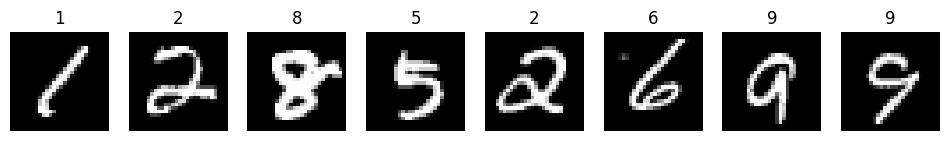

In [ ]:
# Test the download
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(str(labels[i].item()))
    ax.axis("off")
plt.show()


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=400, latent_dim=20):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # x shape: [B, 1, 28, 28] or [B, 784]
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h = F.relu(self.fc3(z))
        x_hat = torch.sigmoid(self.fc4(h))  # outputs in (0,1) for BCE
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [11]:
def vae_loss(recon_x, x, mu, logvar, reduction='sum'):
    # recon_x and x should be shaped [B, 784] and values in [0,1]
    # Reconstruction loss: BCE per pixel
    # Use 'sum' reduction to match KL which is summed per sample
    bce = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction=reduction)
    # KL divergence (analytic)
    # Sum over latent dims, then sum over batch if reduction='sum'
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kl, bce, kl


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # shape [B,1,28,28]
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kl = vae_loss(recon_batch, data, mu, logvar, reduction='sum')
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Avg loss per datapoint: {avg_loss:.4f}")


Epoch 1, Avg loss per datapoint: 190.6905
Epoch 2, Avg loss per datapoint: 167.6327
Epoch 3, Avg loss per datapoint: 163.5012
Epoch 4, Avg loss per datapoint: 161.1127
Epoch 5, Avg loss per datapoint: 159.4846
Epoch 6, Avg loss per datapoint: 158.1466
Epoch 7, Avg loss per datapoint: 157.0787
Epoch 8, Avg loss per datapoint: 156.0644
Epoch 9, Avg loss per datapoint: 155.1656
Epoch 10, Avg loss per datapoint: 154.3940
Epoch 11, Avg loss per datapoint: 153.7578
Epoch 12, Avg loss per datapoint: 153.1478
Epoch 13, Avg loss per datapoint: 152.6489
Epoch 14, Avg loss per datapoint: 152.1261
Epoch 15, Avg loss per datapoint: 151.6972
Epoch 16, Avg loss per datapoint: 151.3081
Epoch 17, Avg loss per datapoint: 150.9163
Epoch 18, Avg loss per datapoint: 150.5598
Epoch 19, Avg loss per datapoint: 150.2144
Epoch 20, Avg loss per datapoint: 149.9574
Epoch 21, Avg loss per datapoint: 149.6694
Epoch 22, Avg loss per datapoint: 149.4706
Epoch 23, Avg loss per datapoint: 149.1442
Epoch 24, Avg loss p

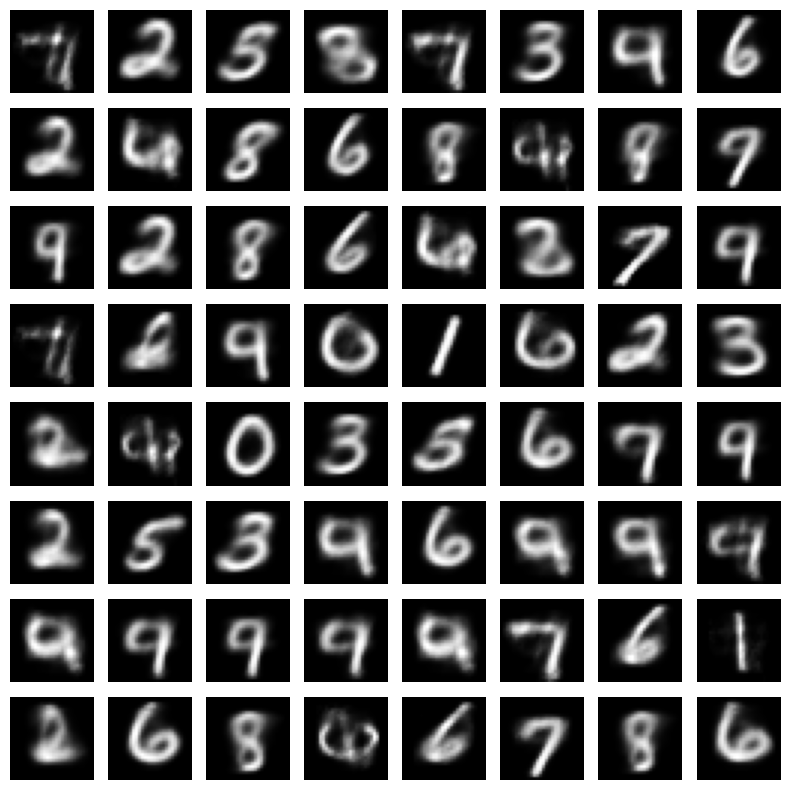

In [54]:
with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    samples = model.decode(z)  # shape [64, 784], values in (0,1)
    samples = samples.view(-1, 1, 28, 28).cpu()


fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [34]:
class CVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        # Input = image + one-hot label
        self.fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        # Input = latent vector + one-hot label
        self.fc3 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, y):
        # y: integer labels -> one-hot encode
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        # concat along feature dim
        xy = torch.cat([x, y_onehot], dim=1)
        h = F.relu(self.fc1(xy))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        zy = torch.cat([z, y_onehot], dim=1)
        h = F.relu(self.fc3(zy))
        out = torch.sigmoid(self.fc4(h))
        return out

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, y)
        return recon_x, mu, logvar

In [35]:
def vae_loss(recon_x, x, mu, logvar, reduction='sum'):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction=reduction)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = CVAE(latent_dim=2).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    model2.train()
    train_loss = 0.0
    for x, y in train_loader:
        x = x.view(-1, 784).to(device)
        y = y.to(device)
        optimizer2.zero_grad()
        recon_x, mu, logvar = model2(x, y)
        loss, BCE, KLD = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer2.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Avg loss per datapoint: {avg_loss:.4f}")

Epoch 1, Avg loss per datapoint: 178.7701
Epoch 2, Avg loss per datapoint: 147.9138
Epoch 3, Avg loss per datapoint: 142.8785
Epoch 4, Avg loss per datapoint: 140.1312
Epoch 5, Avg loss per datapoint: 138.3151
Epoch 6, Avg loss per datapoint: 136.9730
Epoch 7, Avg loss per datapoint: 135.9775
Epoch 8, Avg loss per datapoint: 135.2040
Epoch 9, Avg loss per datapoint: 134.5367
Epoch 10, Avg loss per datapoint: 134.0056
Epoch 11, Avg loss per datapoint: 133.5513
Epoch 12, Avg loss per datapoint: 133.1773
Epoch 13, Avg loss per datapoint: 132.8472
Epoch 14, Avg loss per datapoint: 132.5485
Epoch 15, Avg loss per datapoint: 132.3056
Epoch 16, Avg loss per datapoint: 132.0728
Epoch 17, Avg loss per datapoint: 131.8715
Epoch 18, Avg loss per datapoint: 131.7364
Epoch 19, Avg loss per datapoint: 131.5836
Epoch 20, Avg loss per datapoint: 131.4027
Epoch 21, Avg loss per datapoint: 131.2473
Epoch 22, Avg loss per datapoint: 131.1629
Epoch 23, Avg loss per datapoint: 131.0022
Epoch 24, Avg loss p

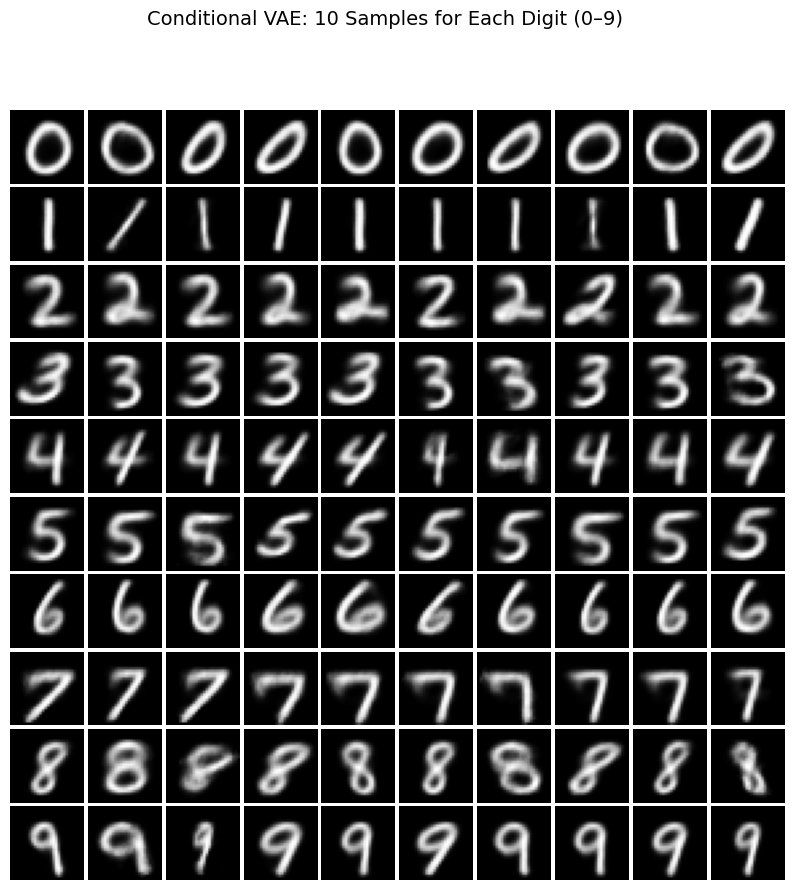

In [53]:
model2.eval()
n_samples_per_digit = 10
num_classes = 10

with torch.no_grad():
    z = torch.randn(num_classes * n_samples_per_digit, model2.latent_dim).to(device)
    y = torch.arange(0, num_classes).repeat_interleave(n_samples_per_digit).to(device)
    samples = model2.decode(z, y).view(-1, 1, 28, 28).cpu()

fig, axes = plt.subplots(num_classes, n_samples_per_digit, figsize=(10, 10))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(num_classes):
    for j in range(n_samples_per_digit):
        ax = axes[i, j]
        ax.imshow(samples[i * n_samples_per_digit + j][0], cmap='gray')
        ax.axis('off')

plt.suptitle("Conditional VAE: 10 Samples for Each Digit (0–9)", fontsize=14)
plt.show()